In [14]:
import sys
import os
import pandas as pd
current_path = os.getcwd()
parent_dir = os.path.join(current_path, "..")
print("Current working directory:", current_path)
print("Path to the parent directory:",parent_dir)
sys.path.append(parent_dir)
import simulator as sm
import numpy as np
import astropy.units as U
from casatasks import exportfits, simobserve, tclean, gaincal, applycal
from casatools import table
from casatools import simulator as casa_simulator
import random
import shutil
from astropy.constants import c
import math
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit


Current working directory: /home/astro/Documents/GitHub/ALMASim/experimental
Path to the parent directory: /home/astro/Documents/GitHub/ALMASim/experimental/..


In [96]:
def convert_to_j2000_string(ra_deg, dec_deg):
  """Converts RA and Dec in degrees to J2000 notation string format (e.g., "J2000 19h30m00 -40d00m00").

  Args:
      ra_deg (float): Right Ascension in degrees (0 to 360).
      dec_deg (float): Declination in degrees (-90 to 90).

  Returns:
      str: J2000 RA and Dec string ("J2000 hh:mm:ss.sss +/- dd:mm:ss.sss").

  Raises:
      ValueError: If RA or Dec values are outside valid ranges.
  """

  # Validate input values
  if not (0 <= ra_deg < 360):
      raise ValueError("Right Ascension (RA) must be between 0 and 360 degrees.")
  if not (-90 <= dec_deg <= 90):
      raise ValueError("Declination (Dec) must be between -90 and 90 degrees.")

  # Convert RA to sexagesimal string (hours:minutes:seconds)
  hours = int(ra_deg / 15)
  minutes = int((ra_deg % 15) * 60)
  seconds = (ra_deg % 15 - minutes / 60) * 3600  # Ensure higher precision

  ra_string = f"{hours:02d}h{minutes:02d}m{seconds:06.3f}"

  # Convert Dec to sexagesimal string (degrees:minutes:seconds)
  dec_dir = "+" if dec_deg >= 0 else "-"
  dec_deg = abs(dec_deg)
  degrees = int(dec_deg)
  minutes = int((dec_deg % 1) * 60)
  seconds = int((dec_deg % 1 - minutes / 60) * 3600)  # Ensure higher precision
  dec_string = f"{dec_dir}{degrees:02d}d{minutes:02d}m{seconds:02d}"

  # Combine RA and Dec strings in J2000 format
  return f"J2000 {ra_string} {dec_string}"

def convert_range_from_GHz_to_km_s(central_freq, central_velocity, freq_range):
    freq_band = freq_range[1] - freq_range[0]
    freq_band = freq_band * U.GHz
    dv = (c * freq_band  / central_freq).to(U.km / U.s)
    return dv

def estimate_alma_beam_size(central_frequency_ghz, max_baseline_km):
  """
  Estimates the beam size of the Atacama Large Millimeter/submillimeter Array (ALMA) in arcseconds.

  This function provides an approximation based on the theoretical relationship between
  observing frequency and maximum baseline. The formula used is:
  beam_size = (speed_of_light / central_frequency) / max_baseline * (180 / pi) * 3600 arcseconds
  [km]/[s] * [s] / [km] = [radians] * [arcsec /radian] * [arcseconds/degree]

  Args:
      central_frequency_ghz: Central frequency of the observing band in GHz (float).
      max_baseline_km: Maximum baseline of the antenna array in kilometers (float).

  Returns:
      Estimated beam size in arcseconds (float).

  Raises:
      ValueError: If either input argument is non-positive.
  """

  # Input validation
  if central_frequency_ghz <= 0 or max_baseline_km <= 0:
    raise ValueError("Central frequency and maximum baseline must be positive values.")

  # Speed of light in meters per second
  light_speed = c.to(U.m / U.s).value

  # Convert frequency to Hz
  central_frequency_hz = central_frequency_ghz.to(U.Hz).value

  # Convert baseline to meters
  max_baseline_meters = max_baseline_km.to(U.m).value


  # Theoretical estimate of beam size (radians)
  theta_radians = (light_speed / central_frequency_hz) / max_baseline_meters

  # Convert theta from radians to arcseconds
  beam_size_arcsec = theta_radians * (180 / math.pi) * 3600 * U.arcsec

  return beam_size_arcsec

def insert_pointlike(datacube, amplitude, pos_x, pos_y, pos_z, fwhm_z, n_px, n_chan):
    z_idxs = np.arange(0, n_chan)
    g = sm.gaussian(z_idxs, 1, pos_z, fwhm_z)
    import scipy.integrate as integrate
    #integral = integrate.quad(lambda x: sm.gaussian(x, 1, pos_z, fwhm_z), min(z_idxs), max(z_idxs))
    #g /= integral[0]
    ts = np.zeros((n_px, n_px, n_chan))
    ts[int(pos_x), int(pos_y), :] = amplitude
    for z in range(datacube._array.shape[2]):
        slice_ = g[z] * ts[:, :, z]
        datacube._array[:, :, z] += slice_ * U.Jy * U.pix**-2
    return datacube

def get_fov_from_band(band, antenna_diameter: int = 12):
    light_speed = c.to(U.m / U.s).value
    if band == 1:
        central_freq = 43 * U.GHz  
    elif band == 2:
        central_freq = 67 * U.GHz
    elif band == 3:
        central_freq = 100 * U.GHz
    elif band == 4:
        central_freq = 150 * U.GHz
    elif band == 5:
        central_freq = 217 * U.GHz
    elif band == 6:
        central_freq = 250 * U.GHz
    elif band == 7:
        central_freq = 353 * U.GHz
    elif band == 8:
        central_freq = 545 * U.GHz
    elif band == 9:
        central_freq = 650 * U.GHz    
    elif band == 10:
        central_freq = 868.5 * U.GHz
    central_freq = central_freq.to(U.Hz).value
    central_freq_s = 1 / central_freq
    wavelength = light_speed * central_freq_s
    # this is the field of view in Radians
    fov = 1.22 * wavelength / antenna_diameter
    # fov in arcsec
    fov = fov * (180 / math.pi) * 3600 * U.arcsec
    return fov

def get_max_baseline_from_antenna_config(antenna_config):
    """
    takes an antenna configuration .cfg file as input and outputs
    """
    positions = []
    with open(antenna_config, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if not line.strip().startswith('#'):
                if '\t' in line:
                    row = [x for x in line.split("\t")][:3]
                else:
                    row = [x for x in line.split(" ")][:3]
                positions.append([float(x) for x in row])  
    positions = np.array(positions)
    max_baseline = 2 * np.max(np.sqrt(positions[:, 0]**2 + positions[:, 1]**2 + positions[:, 2])) / 1000
    return max_baseline

def compute_redshift(rest_frequency, observed_frequency):
    """
    Computes the redshift of a source given the rest frequency and the observed frequency.

    Args:
        rest_frequency (astropy Unit): Rest frequency of the source in GHz.
        observed_frequency (astropy Unit): Observed frequency of the source in GHz.

    Returns:
        float: Redshift of the source.

    Raises:
        ValueError: If either input argument is non-positive.
    """
    # Input validation
    if rest_frequency <= 0 or observed_frequency <= 0:
        raise ValueError("Rest and observed frequencies must be positive values.")

    # Compute redshift
    redshift = (rest_frequency.value - observed_frequency.value) / rest_frequency.value
    return redshift

def luminosity_to_jy(velocity, data, rest_frequency: float = 115.27):
        """
        This function takes as input a pandas db containing luminosities in K km s-1 pc2, redshifts, and luminosity distances in Mpc, 
        and returns the brightness values in Jy.
        
        Parameters:
        velocity (float): The velocity dispersion assumed for the line (Km s-1).
        data (pandas.DataFrame): A pandas DataFrame containing the data.
        rest_frequency (float): The rest frequency of the line in GHz. Defaults to 115.27 GHz for CO(1-0).

        Output:
        sigma: numpy.ndarray: An array of brightness values in Jy.

        """
        alpha = 3.255 * 10**7
        sigma = (data['Luminosity(K km s-1 pc2)'] * ( (1 + data['#redshift']) * rest_frequency **2)) / (alpha * velocity * (data['luminosity distance(Mpc)']**2))
        redshift = data['#redshift'].values
        return sigma

def exponential_func(x, a, b):
        """
        Exponential function used to fit the data.
        """
        return a * np.exp(-b * x)
        
def sample_from_brightness_given_redshift(velocity, rest_frequency, data_path, redshift):
    data = pd.read_csv(data_path, sep='\t')
    # Calculate the brightness values (sigma) using the provided velocity
    sigma = luminosity_to_jy(velocity, data, rest_frequency)
    # Extract the redshift values from the data
    redshifts = data['#redshift'].values
    # Generate evenly spaced redshifts for sampling
    np.random.seed(42)
    # Fit an exponential curve to the data
    popt, pcov = curve_fit(exponential_func, redshifts, sigma, )
    # Sample the brightness values using the exponential curve
    sampled_brightness = exponential_func(redshift, *popt) + np.min(sigma)
    return sampled_brightness

from collections import OrderedDict
def redshift_to_snapshot(redshift):
    snap_db = {
        0: 20.05,
        1: 14.99,
        2: 11.98,
        3: 10.98,
        4: 10.00,
        5: 9.390,
        6: 9.000,
        7: 8.450,
        8: 8.010,
        9: 7.600,
        10: 7.24,
        11:	7.01,
        12:	6.49,
        13:	6.01,
        14:	5.85,
        15:	5.53,
        16:	5.23,
        17:	5.00,
        18:	4.66,
        19:	4.43,
        20:	4.18,
        21:	4.01,
        22:	3.71,
        23:	3.49,
        24:	3.28,
        25:	3.01,
        26:	2.90,
        27:	2.73,
        28:	2.58,
        29:	2.44,
        30:	2.32,
        31:	2.21,
        32:	2.10,
        33:	2.00,
        34:	1.90,
        35:	1.82,
        36:	1.74,
        37:	1.67,
        38:	1.60,
        39:	1.53,
        40:	1.50,
        41:	1.41,
        42:	1.36,
        43:	1.30,
        44:	1.25,
        45:	1.21,
        46:	1.15,
        47:	1.11,
        48:	1.07,
        49:	1.04,
        50:	1.00,
        51:	0.95,
        52:	0.92,
        53:	0.89,
        54:	0.85,
        55:	0.82,
        56:	0.79,
        57:	0.76,
        58:	0.73,
        59:	0.70,
        60:	0.68,
        61:	0.64,
        62:	0.62,
        63:	0.60,
        64:	0.58,
        65:	0.55,
        66:	0.52,
        67:	0.50,
        68:	0.48,
        69:	0.46,
        70:	0.44,
        71:	0.42,
        72:	0.40,
        73:	0.38,
        74:	0.36,
        75:	0.35,
        76:	0.33,
        77:	0.31,
        78:	0.30,
        79:	0.27,
        80:	0.26,
        81:	0.24,
        82:	0.23,
        83:	0.21,
        84:	0.20,
        85:	0.18,
        86:	0.17,
        87:	0.15,
        88:	0.14,
        89:	0.13,
        90:	0.11,
        91:	0.10,
        92:	0.08,
        93:	0.07,
        94:	0.06,
        95:	0.05,
        96:	0.03,
        97:	0.02,
        98:	0.01,
        99:	0,
    }
    snaps, redshifts = list(snap_db.keys())[::-1], list(snap_db.values())[::-1]
    for i in range(len(redshifts) - 1):
        if redshift >= redshifts[i] and redshift < redshifts[i + 1]:
            return snaps[i]

In [102]:
print(redshift_to_snapshot(0.519))

67


In [4]:
metadata = pd.read_csv(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))
metadata.info()
source_names = metadata['ALMA_source_name'].values
ras = metadata['RA'].values
decs = metadata['Dec'].values
bands = metadata['Band'].values
ang_ress = metadata['Ang.res.'].values
vel_ress = metadata['Vel.res.'].values
fovs = metadata['FOV'].values
obs_dates = metadata['Obs.date'].values
pwvs = metadata['PWV'].values
int_times = metadata['Int.Time'].values
total_times = metadata['Total.Time'].values
bandwidths = metadata['Bandwidth'].values
freqs = metadata['Freq'].values
freq_supports = metadata['Freq.sup.'].values
antenna_arrays = metadata['antenna_arrays'].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ALMA_source_name         181 non-null    object 
 1   Band                     181 non-null    int64  
 2   PWV                      181 non-null    float64
 3   SB_name                  181 non-null    object 
 4   Vel.res.                 181 non-null    float64
 5   Ang.res.                 181 non-null    float64
 6   RA                       181 non-null    float64
 7   Dec                      181 non-null    float64
 8   FOV                      181 non-null    float64
 9   Int.Time                 181 non-null    float64
 10  Total.Time               181 non-null    float64
 11  Cont_sens_mJybeam        181 non-null    float64
 12  Line_sens_10kms_mJybeam  181 non-null    float64
 13  Obs.date                 181 non-null    object 
 14  Bandwidth                1

In [103]:
idx = 10
fixing_dim = True
output_dir = current_path
plot_dir = current_path
project = 'test'
if not os.path.exists(os.path.join(output_dir, project)):
    os.mkdir(os.path.join(output_dir, project))
source_name = source_names[idx]
ra = ras[idx] * U.deg
dec = decs[idx] * U.deg
band = bands[idx]
ang_res = ang_ress[idx] * U.arcsec
vel_res = vel_ress[idx] * U.km / U.s
obs_date = obs_dates[idx]
pwv = pwvs[idx]
int_time = int_times[idx] * U.s
total_time = total_times[idx] * U.s
freq = freqs[idx]
freq_support = freq_supports[idx]
freq_sup = freq_supports[idx].split(' U ')[0].split(',')[1]
freq_sup = float(sm.remove_non_numeric(freq_sup)) * U.kHz
freq_sup = freq_sup.to(U.MHz)
band_range = sm.get_band_range(int(band))
band_range = band_range[1] - band_range[0]
band_range = band_range * U.GHz
source_freq = freq * U.GHz
central_freq = sm.get_band_central_freq(int(band)) * U.GHz
antenna_array = antenna_arrays[idx]
sm.generate_antenna_config_file_from_antenna_array(antenna_array, parent_dir, output_dir)
antennalist = os.path.join(output_dir, "antenna.cfg")
antenna_name = 'antenna'
max_baseline = get_max_baseline_from_antenna_config(antennalist) * U.km
print("Max Baseline: ", max_baseline)
rest_frequency = 115.271 * U.GHz
print("Source Name:", source_name)
print("RA {} Dec {}".format(round(ra.value, 2), round(dec.value,2)))
pos_string = convert_to_j2000_string(ra.value, dec.value)
print("J200 Coordinates:", pos_string)
print("Band:", band)
print("Angular Resolution:", ang_res)
print("Velocity Resolution:", vel_res)
print("Observation Date:", obs_date)
print("PWV:", pwv)
print("Integration Time:", int_time)
print("Total Time:", total_time)
print("Central Frequency:", central_freq)
print("Source Frequency:", source_freq)
print("Rest Frequency:", rest_frequency)
redshift = compute_redshift(rest_frequency, source_freq)
brightness = sample_from_brightness_given_redshift(vel_res, rest_frequency.value, os.path.join(parent_dir, 'brightnes', 'CO10.dat'), redshift)
print("Redshift:", redshift)
brightness = 1
print("Brightness:", brightness)
snapshot = redshift_to_snapshot(redshift)
print("Snapshot:", snapshot)
print('Generated Antenna Configuration from metadata, max baseline:', max_baseline)
fov = get_fov_from_band(band)
print("Field of View:", fov)
beam_size = estimate_alma_beam_size(central_freq, max_baseline_corr)
print("Estimated Beam Size:", beam_size)
print("Frequency Support:", freq_sup)
n_channels = int(band_range / freq_sup)
cell_size = beam_size / 5
n_pixels = int(1.5 * fov.to(U.arcsec) / cell_size)
fix_pixels = input("The FOV of {} arcsec sampled at {} arcsec would result in {} pixels.\n Would you like to fix the number of pixels? (y/n)".format(round(fov.value, 2), round(cell_size.value, 3), n_pixels))
if fix_pixels == 'y':
    n_pixels = int(input("Enter the number of pixels:"))
    cell_size = fov.to(U.arcsec) / n_pixels
central_channel_index = n_channels // 2
source_channel_index = int(central_channel_index * source_freq / central_freq)
fix_channels = input("Source Emission Line Frequency is {} GHz, band {} central frequency is {}.\n The bandwidth of {} GHz sampled at {} MHz would result in {} channels.\n Distance between the central frequency and the source emission line is {} channels.\n Would you like to fix the number of channels? (y/n)".format(round(source_freq.value,2), band, central_freq, band_range.to(U.GHz), round(freq_sup.to(U.MHz).value, 2), n_channels, abs(source_channel_index - central_channel_index)))
if fix_channels == 'y':
    n_channels = int(input("Enter the number of channels:"))
    central_channel_index = n_channels // 2
    source_channel_index = int(central_channel_index * source_freq / central_freq)

print("Central Channel Index:", central_channel_index)
print("Source Channel Index:", source_channel_index)

Max Baseline:  2.1633061302301577 km
Source Name: CID-247
RA 150.05 Dec 1.87
J200 Coordinates: J2000 10h02m48.476 +01d52m00
Band: 3
Angular Resolution: 1.1204289447883438 arcsec
Velocity Resolution: 23322.320910218947 km / s
Observation Date: 2019-04-05
PWV: 5.4633894
Integration Time: 4294.08 s
Total Time: 58207.046294 s
Central Frequency: 100.0 GHz
Source Frequency: 100.00001116277804 GHz
Rest Frequency: 115.271 GHz
Redshift: 0.13247901759524913
Brightness: 1
Snapshot: 89
Generated Antenna Configuration from metadata, max baseline: 2.1633061302301577 km
Field of View: 62.867243818105955 arcsec
Estimated Beam Size: 0.2858431934325073 arcsec
Frequency Support: 7.812010000000001 MHz
Central Channel Index: 2048
Source Channel Index: 2048


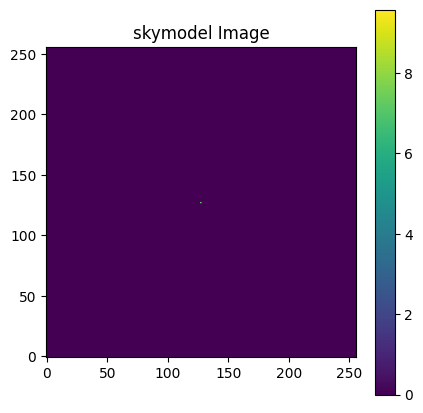

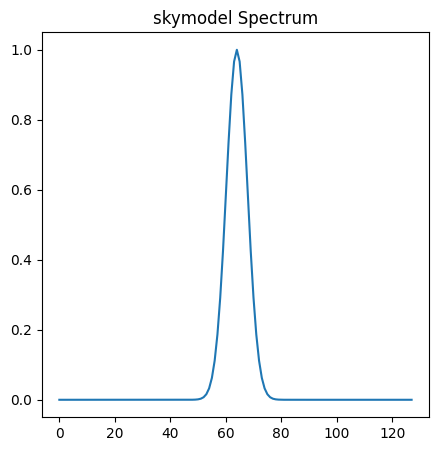

In [62]:
datacube = sm.DataCube(
  n_px_x=n_pixels, 
  n_px_y=n_pixels,
  n_channels=n_channels, 
  px_size=cell_size, 
  channel_width=freq_sup, 
  velocity_centre=central_freq, 
  ra=ra, 
  dec=dec)
wcs = datacube.wcs
pos_x, pos_y, _ = wcs.sub(3).wcs_world2pix(ra, dec, central_freq, 0)
pos_z = int(source_channel_index)
fwhm_z = np.random.randint(3, 10)
datacube = insert_pointlike(datacube, brightness, pos_x, pos_y, pos_z, fwhm_z, n_pixels, n_channels)
filename = os.path.join(output_dir, project, 'skymodel_{}.fits'.format(idx))
sm.write_datacube_to_fits(datacube, filename)
sm.plot_skymodel(filename, idx, plot_dir, show=True)
skymodel, sky_header = sm.load_fits(filename)

Adding Atmospheric Noise using a scale factor of 0.5 for thropospheric phase
Found no unflagged data at:   (time=2014/01/01/00:23:36.1 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/01:35:10.2 field=1 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/13:30:51.0 field=2 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/14:42:25.1 field=0 spw=0 chan=0)
Found no unflagged data at:   (time=2014/01/01/15:53:59.2 field=1 spw=0 chan=0)


2024-04-03 11:57:03	WARN	task_tclean::SIImageStore::restore (file /source/casa6/casatools/src/code/synthesis/ImagerObjects/SIImageStore.cc, line 2265)	Restoring with an empty model image. Only residuals will be processed to form the output restored image.


Saving Dirty and Clean Cubes


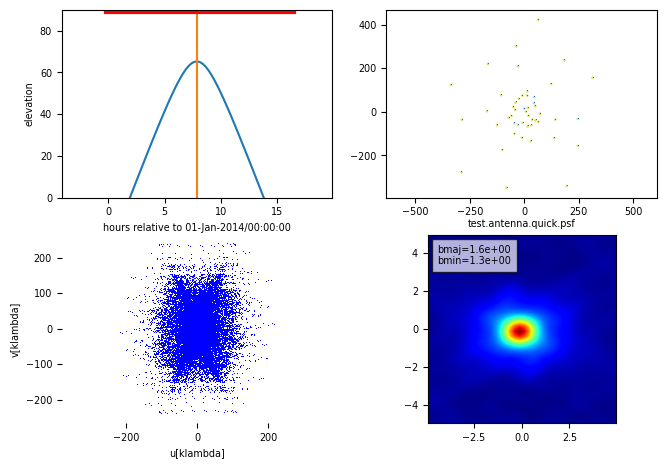

In [63]:
simobserve(
    project=project, 
    skymodel=filename,
    obsmode="int",
    setpointings=True,
    thermalnoise="tsys-atm",
    antennalist=antennalist,
    indirection=pos_string,
    #indirection="J2000 19h30m00 -40d00m00",
    incell="{}arcsec".format(cell_size.value),
    incenter='{}GHz'.format(central_freq.value),
    inwidth="{}MHz".format(freq_sup.value),
    integration="{}s".format(int_time.value),
    totaltime="{}s".format(total_time.value),
    user_pwv=pwv,
    )
scale = 0.5
print('Adding Atmospheric Noise using a scale factor of {} for thropospheric phase'.format(scale))
    # scale is a multiplicative factor for the thropospheric phase 
    # which is a delay in the propagation of radio waves in the atmosphere
    # caused by the refractive index of the throphosphere
sm.simulate_atmospheric_noise(
    os.path.join(output_dir, project), 
    scale, 
    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)), 
    antennalist)
gain_error_amplitude = random.gauss(0.001, 0.1)
sm.simulate_gain_errors(
    os.path.join(output_dir, project, "{}.{}.noisy.ms".format(project, antenna_name)),
    gain_error_amplitude
)
tclean(
    vis=os.path.join(project, "{}.{}.noisy.ms".format(project, antenna_name)),
    imagename=os.path.join(project, '{}.{}'.format(project, antenna_name)),
    imsize=[int(n_pixels), int(n_pixels)],
    cell="{}".format(beam_size),
    phasecenter=pos_string,
    specmode="cube",
    niter=0,
    fastnoise=False,
    calcpsf=True,
    pbcor=True,
    pblimit=0.2, 
    )

print('Saving Dirty and Clean Cubes')
exportfits(imagename=os.path.join(project, '{}.{}.image'.format(project, antenna_name)), 
       fitsimage=os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"), overwrite=True)
exportfits(imagename=os.path.join(project, '{}.{}.skymodel'.format(project, antenna_name)), 
        fitsimage=os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"), overwrite=True)


Sky peak flux: 1.0
Dirty peak flux: 0.77124244
Plotting the dirty and clean cubes


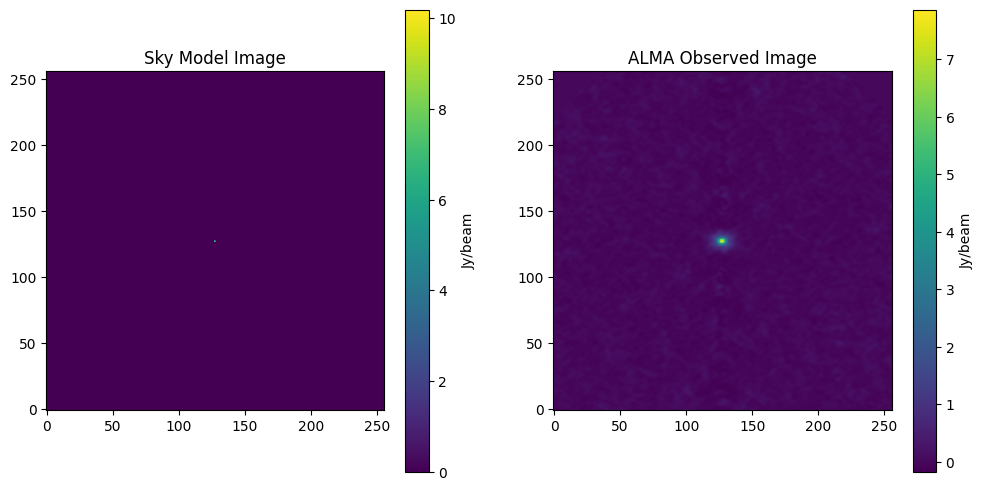

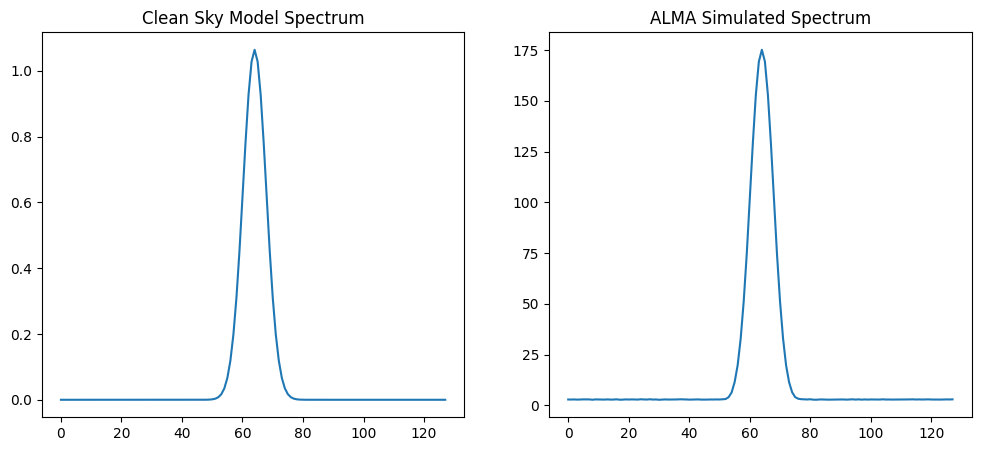

In [65]:
clean, clean_header = sm.load_fits(os.path.join(output_dir, "clean_cube_" + str(idx) +".fits"))
dirty, dirty_header = sm.load_fits(os.path.join(output_dir, "dirty_cube_" + str(idx) +".fits"))
sky_total_flux = np.nansum(skymodel)
dirty_total_flux = np.nansum(dirty)
sky_peak_flux = np.nanmax(skymodel)
dirty_peak_flux = np.nanmax(dirty)
print('Sky peak flux:', sky_peak_flux)
print('Dirty peak flux:', dirty_peak_flux)
print('Plotting the dirty and clean cubes')
clean = clean[0]
dirty = dirty[0]
beam_solid_angle = np.pi * (beam_size / 2) ** 2
pixel_solid_angle = cell_size ** 2
pix_to_beam = beam_solid_angle / pixel_solid_angle
clean_spectrum = np.sum(clean[:, :, :], axis=(1, 2))
dirty_spectrum = np.where(dirty < 0, 0, dirty)
dirty_spectrum = np.nansum(dirty_spectrum[:, :, :], axis=(1, 2))
clean_image = np.sum(clean[:, :, :], axis=0)[np.newaxis, :, :]
dirty_image = np.nansum(dirty[:, :, :], axis=0)[np.newaxis, :, :]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(clean_image[0] * pix_to_beam, origin='lower')
ax[1].imshow(dirty_image[0] * pix_to_beam, origin='lower')
plt.colorbar(ax[0].imshow(clean_image[0] * pix_to_beam, origin='lower'), ax=ax[0], label='Jy/beam')
plt.colorbar(ax[1].imshow(dirty_image[0] * pix_to_beam, origin='lower'), ax=ax[1], label='Jy/beam')
ax[0].set_title('Sky Model Image')
ax[1].set_title('ALMA Observed Image')
plt.show()


fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(clean_spectrum * pix_to_beam)
ax[1].plot(dirty_spectrum * pix_to_beam)
ax[0].set_title('Clean Sky Model Spectrum')
ax[1].set_title('ALMA Simulated Spectrum')
plt.show()